# IS318 - Machine Learning
## TP2 - Linear classification

The goal of this TP is to experiment with linear models for classification.

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 1. Dataset

We will work with a synthetic binary classification dataset:

(500, 2) (500,)


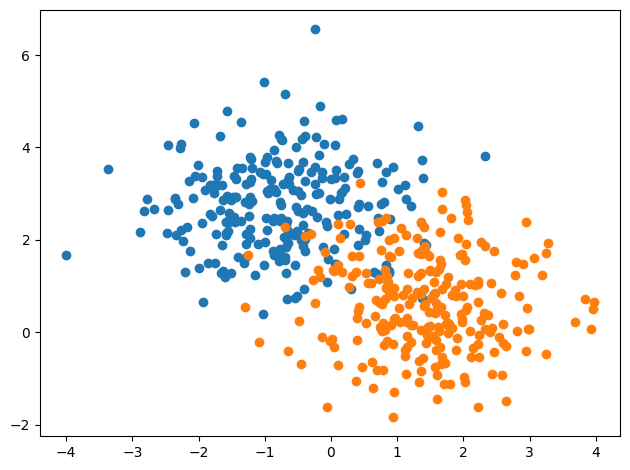

In [123]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, center_box=(-3, 3), random_state=42) # Easy
# X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2) # Hard
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0])
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1])
plt.tight_layout()
print(X.shape, y.shape)
plt.show()
plt.close()

Before implementing a classification method, we will apply some preprocessing steps.

**(Question)** Preprocessing: normalize the data such that it has zero mean and unit variance. To do that, for each feature, substract the mean and divide by the standard deviation over the samples. Plot the data.

This procedure is called *standardization*.
It is useful for numerical stability (notably for gradient descent).

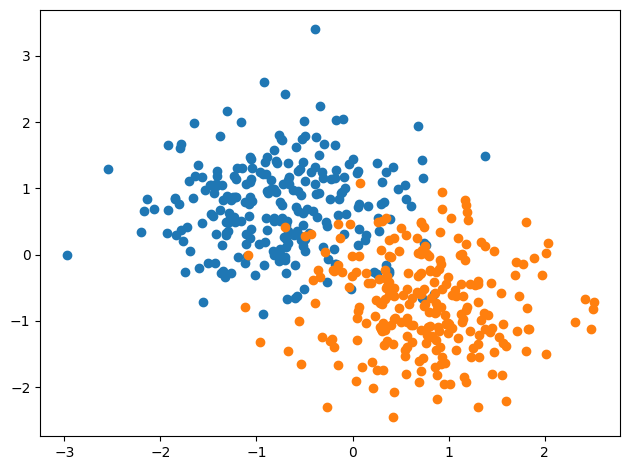

In [124]:
# Calculate mean and standard deviation for each feature
mean_values = np.mean(X, axis=0)
std_values = np.std(X, axis=0)

# Normalized data
X_normalized = (X - mean_values)/std_values

# Plotting the normalized data
plt.scatter(X_normalized[:, 0][y == 0], X_normalized[:, 1][y == 0])
plt.scatter(X_normalized[:, 0][y == 1], X_normalized[:, 1][y == 1])
plt.tight_layout()
plt.show()
plt.close()

In [125]:
assert np.allclose(X_normalized.mean(axis=0), 0.)
assert np.allclose(X_normalized.var(axis=0), 1.)

**(Question)** Plot the data points as above to observe the difference of standardization.

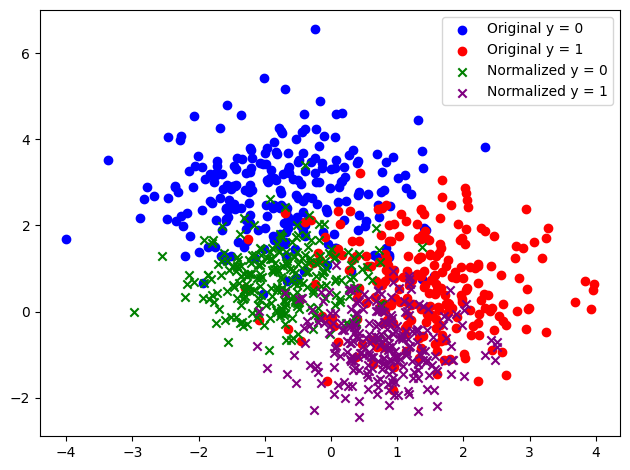

In [126]:
# Plot the original data
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], label='Original y = 0', color='blue')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], label='Original y = 1', color='red')

# Plot the normalized data
plt.scatter(X_normalized[:, 0][y == 0], X_normalized[:, 1][y == 0], label='Normalized y = 0', color='green', marker='x')
plt.scatter(X_normalized[:, 0][y == 1], X_normalized[:, 1][y == 1], label='Normalized y = 1', color='purple', marker='x')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

**(Question)** As usual, add a column with ones to simplify dot product notation. Then, split the dataset into training and validation sets.

In [127]:
# YOUR CODE HERE
X_stacked = np.column_stack((np.ones(X_normalized.shape[0]), X_normalized))

# splitting by 75% for training and 25% for validation
split_percentile = len(X_stacked)*75//100
X_train, X_valid = X_stacked[:split_percentile], X_stacked[split_percentile:]
y_train, y_valid = y[:split_percentile], y[split_percentile:]

In [128]:
assert X_stacked.shape[1] == 3
assert np.all(X_stacked[:, 0] == 1.)

**(Question)** With real data, it is considered wrong to apply standardization before splitting the dataset. Can you explain why?

## **Answer**
**If we standardize the dataset before splitting, that means we are going to use data outside our training dataset to fit our model. And worse this data is from our validation set so the validation dataset is no longer something that's entirely new to our model.**

### 2. Logistic regression

**(Question)** Complete the `LogisticRegression` class below to implement logistic regression for binary classification.
- For the `fit` method, implement a simple gradient descent on the binary cross entropy loss. Record the evolution of the loss over the iterations in the `loss_hist` attribute.
- For the `predict` method, compute predictions from the model and return the binary decisions by thresholding at $0.5$.

In [129]:
class LogisticRegression():
    
    def __init__(self, learning_rate=0.1, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.W = None
        self.loss_hist = np.zeros(self.n_iters)
        self.threshold = 0.5
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def binary_cross_entropy(self, y, y_pred):
        N = len(y)
        y_acc = np.clip(y_pred, 10**-6, 1 - 10**-6)
        return (-1/N)*np.sum([y[i]*np.log(y_acc[i]) + (1 - y[i])*np.log(1- y_acc[i]) for i in range(N)])
        
    def fit(self, X, y):
        self.W = np.zeros(X.shape[1])
        N = len(y)
        for i in range(self.n_iters) :
            y_pred = self.sigmoid(np.dot(X, self.W))
            self.W -= self.learning_rate*(np.dot(X.T, (y_pred - y))/N)
            self.loss_hist[i] = self.binary_cross_entropy(y, y_pred)

    
    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.W))
        return y_pred >= self.threshold

**(Question)** Apply your logistic regression model with default arguments to our synthetic dataset. Report the classification accuracy on the training and validation sets.

In [130]:
# YOUR CODE HERE
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)

Binary cross entropy for the validation set : 1.2157658411003922
Accuracy for the validation set : 0.912


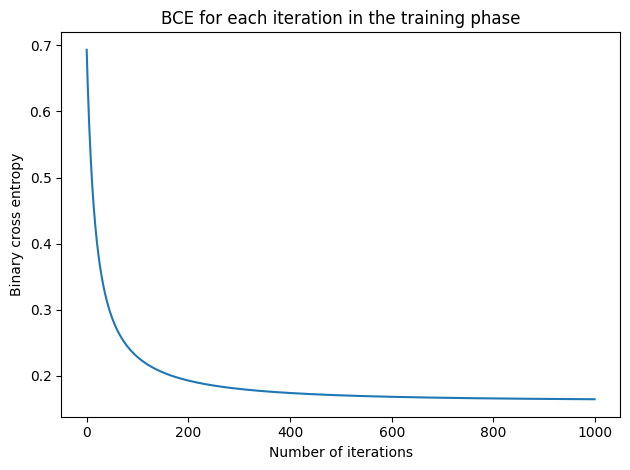

In [131]:
print("Binary cross entropy for the validation set :", lr.binary_cross_entropy(y_valid, y_pred))
print("Accuracy for the validation set :", accuracy_score(y_valid, y_pred))
plt.plot(np.arange(lr.n_iters), lr.loss_hist)
plt.xlabel("Number of iterations")
plt.ylabel("Binary cross entropy")
plt.title("BCE for each iteration in the training phase")
plt.tight_layout()
plt.show()
plt.close()

**(Question)** Plot the decision boundary on top on the data points.

*Hint*: to compute the decision boundary, start from its equation and transform it to an usual affine formulation.

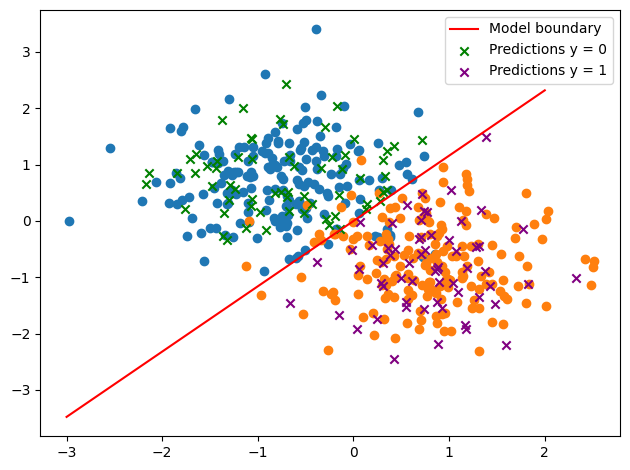

In [132]:
# Plotting the data
plt.scatter(X_train[:, 1:][:, 0][y_train == 0], X_train[:, 1:][:, 1][y_train == 0])
plt.scatter(X_train[:, 1:][:, 0][y_train == 1], X_train[:, 1:][:, 1][y_train == 1])

# Plotting the boundary
X_sample = np.linspace(-3, 2, 500)
plt.plot(X_sample, -(X_sample*lr.W[1] + lr.W[0])/lr.W[2], color="red", label="Model boundary")

# Plotting the predictions
plt.scatter(X_valid[:, 1:][:, 0][y_pred == 0], X_valid[:, 1:][:, 1][y_pred == 0], label='Predictions y = 0', color='green', marker='x')
plt.scatter(X_valid[:, 1:][:, 0][y_pred == 1], X_valid[:, 1:][:, 1][y_pred == 1], label='Predictions y = 1', color='purple', marker='x')

plt.tight_layout()
plt.legend()
plt.show()
plt.close()

**(Question)** Play around with the `learning_rate` and `n_iters` hyperparameters to see the impact on gradient descent convergence.
Plot the evolution of the loss over the iterations for different learning rates.
Comment the results.

In [133]:
# Initiating hyperparameters
learning_rates = np.linspace(0, 1, 10)
n_iters_arr = np.arange(0, 10000, 5000)
count = 0
gradient_descent_values = []

# Hypertuning
for learning_rate_arg in learning_rates :
    for n_iters_arg in n_iters_arr :
        count += 1
        print(count, "/", len(learning_rates)*len(n_iters_arr), end="\r")
        lr = LogisticRegression(learning_rate=learning_rate_arg, n_iters=n_iters_arg)
        lr.fit(X_train, y_train)
        y_pred_tuning = lr.predict(X_valid)
        N = len(y_valid)
        gradient_descent_values.append(np.dot(X_valid.T, (y_pred_tuning - y_valid))/N)

print("\n", np.array(gradient_descent_values))

20 / 20
 [[ 0.488      -0.33853012  0.38678676]
 [ 0.488      -0.33853012  0.38678676]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]
 [ 0.488      -0.33853012  0.38678676]
 [-0.024       0.03140377 -0.00662957]]


## **Answer :**
**hi**

### 3. Gaussian generative model

**(Question)** Complete the `GaussianGenerativeModel` class below.

In [134]:
class GaussianGenerativeModel():
    def __init__(self):
        self.mu0 = None
        self.mu1 = None
        self.phi = None
        self.Sigma = None
        self.W = None
        self.b = None
        self.threshold = 0.5
        
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def fit(self, X, y):
        N0, N1 = sum(y == 0), sum(y == 1)
        self.phi = N1/(N0 + N1)
        self.mu1 = sum(np.array([X[i]*y[i] for i in range(N0+N1)]))/N1
        self.mu0 = sum(np.array([X[i]*(1 - y[i]) for i in range(N0+N1)]))/N0
        mu = [self.mu0, self.mu1]
        self.Sigma = sum([np.dot((X[i] - mu[y[i]])[:, np.newaxis], (X[i] - mu[y[i]])[:, np.newaxis].T) for i in range(N1 + N0)])/(N1 + N0)
        sigma_inv = np.linalg.inv(self.Sigma)
        self.W = np.dot(sigma_inv, (mu[1] - mu[0])).flatten()
        self.b = (np.log(self.phi/(1-self.phi)) - \
                (np.dot(np.dot(mu[1][:, np.newaxis].T, sigma_inv), mu[1][:, np.newaxis]))/2 + \
                (np.dot(np.dot(mu[0][:, np.newaxis].T, sigma_inv), mu[0][:, np.newaxis]))/2)

    def predict(self, X):
        y_pred = self.sigmoid(np.dot(X, self.W) + self.b)
        return (y_pred >= self.threshold)[0]
    

**(Question)** Apply your gaussian generative model to our synthetic dataset. Report the classification accuracy on the training and validation sets.

*Hint:* The column with ones is not needed for this model.

In [135]:
# YOUR CODE HERE
ggm = GaussianGenerativeModel()
# exclude b weight from the trainning set
ggm.fit(X_train[:, 1:], y_train)
# ggm.predict(X_valid[:, 1:])
y_pred_ggm_valid = ggm.predict(X_valid[:, 1:])
y_pred_ggm_train = ggm.predict(X_train[:, 1:])

print("accuracy GaussianGenerativeModel training :", sum(y_pred_ggm_train == y_train)/len(y_train))
print("accuracy GaussianGenerativeModel validation :", sum(y_pred_ggm_valid == y_valid)/len(y_valid))

accuracy GaussianGenerativeModel training : 0.9466666666666667
accuracy GaussianGenerativeModel validation : 0.912


**(Question)** Plot the decision boundary on top on the data points and compare it with the one obtained with logistic regression.

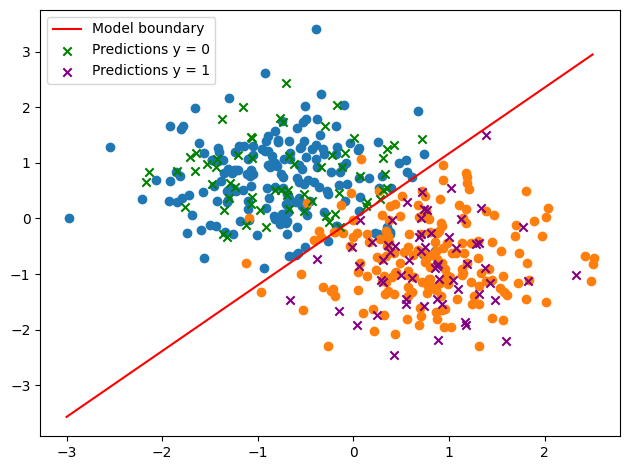

In [136]:
# Plotting the data
plt.scatter(X_train[:, 1:][:, 0][y_train == 0], X_train[:, 1:][:, 1][y_train == 0])
plt.scatter(X_train[:, 1:][:, 0][y_train == 1], X_train[:, 1:][:, 1][y_train == 1])

# Plotting the boundary
X_sample = np.linspace(-3, 2.5, 500)
plt.plot(X_sample, -(X_sample*ggm.W[0] + ggm.b[0, 0])/ggm.W[1], color="red", label="Model boundary")

# Plotting the predictions
plt.scatter(X_valid[:, 1:][:, 0][y_pred_ggm_valid == 0], X_valid[:, 1:][:, 1][y_pred_ggm_valid == 0], label='Predictions y = 0', color='green', marker='x')
plt.scatter(X_valid[:, 1:][:, 0][y_pred_ggm_valid == 1], X_valid[:, 1:][:, 1][y_pred_ggm_valid == 1], label='Predictions y = 1', color='purple', marker='x')

plt.tight_layout()
plt.legend()
plt.show()
plt.close()

### 4. Comparison with `sklearn`

**(Question)** Apply logistic regression using the `LogisticRegression` class from the `scikit-learn` library. Compare the results with your previous implementation.

*Hints:*
- If your features are already augmented with a column of ones, set the `fit_intercept` parameter to `False`
- Set `penalty` (regularization to `None` to match your unregularized implementation

In [137]:
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn
logreg = LogisticRegressionSklearn(fit_intercept=False, penalty=None, random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg_sklearn = logreg.predict(X_valid)
print("BCE for the logisticRegressionSklearn :", LogisticRegression().binary_cross_entropy(y_valid, y_pred_logreg_sklearn))

BCE for the logisticRegressionSklearn : 1.2157658411003922


## **Answer :**
**hi**

### 5. Application to breast cancer dataset

In [138]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

**(Question)** Load the data into `X` and `y` variables. Familiarize yourself with this dataset. What are the dimensions? Explain what they mean.

In [139]:
X_cancer, y_cancer = dataset['data'], dataset['target']

print(X_cancer.shape)

(569, 30)


## **Answer :**
**hi**

**(Question)** Split into train/test and preprocess the data.

In [140]:
# splitting by 75% for training and 25% for validation
split_percentile = len(X_cancer)*75//100
# Calculate mean and standard deviation for each feature
mean_values = np.mean(X_cancer, axis=0)
std_values = np.std(X_cancer, axis=0)

# Normalized data
X_normalized_cancer = (X_cancer - mean_values)/std_values

X_train_cancer, X_valid_cancer = X_normalized_cancer[:split_percentile], X_normalized_cancer[split_percentile:]
y_train_cancer, y_valid_cancer = y_cancer[:split_percentile], y_cancer[split_percentile:]

**(Question)** Apply your implementations of logistic regression and gaussian generative model to this dataset.

In [141]:
# YOUR CODE HERE
ggm_cancer = GaussianGenerativeModel()
ggm_cancer.fit(X_train_cancer, y_train_cancer)
y_pred_ggm_valid_cancer = ggm_cancer.predict(X_valid_cancer)
y_pred_ggm_train_cancer = ggm_cancer.predict(X_train_cancer)

# YOUR CODE HERE
X_train_cancer_stacked = np.column_stack((np.ones(X_train_cancer.shape[0]), X_train_cancer))
X_valid_cancer_stacked = np.column_stack((np.ones(X_valid_cancer.shape[0]), X_valid_cancer))
lr_cancer = LogisticRegression()
lr_cancer.fit(X_train_cancer_stacked, y_train_cancer)
y_pred_lr_valid_cancer = lr_cancer.predict(X_valid_cancer_stacked)
y_pred_lr_train_cancer = lr_cancer.predict(X_train_cancer_stacked)

# accuracy GaussianGenerativeModel
print("accuracy GaussianGenerativeModel training :", sum(y_pred_ggm_train_cancer == y_train_cancer)/len(y_train_cancer))
print("accuracy GaussianGenerativeModel validation :", sum(y_pred_ggm_valid_cancer == y_valid_cancer)/len(y_valid_cancer))

# accuracy LogisticRegression
print("accuracy LogisticRegression training :", sum(y_pred_lr_train_cancer == y_train_cancer)/len(y_train_cancer))
print("accuracy LogisticRegression validation :", sum(y_pred_lr_valid_cancer == y_valid_cancer)/len(y_valid_cancer))

accuracy GaussianGenerativeModel training : 0.9694835680751174
accuracy GaussianGenerativeModel validation : 0.972027972027972
accuracy LogisticRegression training : 0.9812206572769953
accuracy LogisticRegression validation : 0.972027972027972


In [142]:

# WRITE YOUR COMMENT
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_cancer, y_train_cancer)
y_pred_lda_cancer = lda.predict(X_valid_cancer)

accuracy_score(y_pred_lda_cancer, y_valid_cancer)

0.972027972027972

**(Question)** Apply cross-validation (see `sklearn.model_selection`) on your implementations to successively train several models and obtain predictions for the whole dataset.
Comment the results.

In [143]:
# YOUR CODE HERE
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores_lr = []
accuracy_scores_ggm = []

# Loop through each fold for cross-validation
for train_index, test_index in kf.split(X_train_cancer, y_train_cancer):
    X_train, X_test = X_train_cancer[train_index], X_train_cancer[test_index]
    y_train, y_test = y_train_cancer[train_index], y_train_cancer[test_index]


    # Initialize and fit the GGM model
    ggm_cancer = GaussianGenerativeModel()
    ggm_cancer.fit(X_train, y_train)
    y_pred_ggm = ggm_cancer.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_ggm)
    accuracy_scores_ggm.append(accuracy)

    # stacking for LR
    X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
    X_test = np.column_stack((np.ones(X_test.shape[0]), X_test))
    
    # Initialize and fit the LR model
    lr_cancer = LogisticRegression()
    lr_cancer.fit(X_train, y_train)
    y_pred_lr = lr_cancer.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_lr)
    accuracy_scores_lr.append(accuracy)
    
    

print("cross-validation scores for :")
print("LogisticRegression :", np.mean(np.array(accuracy_scores_lr)))
print("GaussianGenerativeModel :", np.mean(np.array(accuracy_scores_ggm)))

cross-validation scores for :
LogisticRegression : 0.9742524916943521
GaussianGenerativeModel : 0.9508305647840531


## **Answer :**
**Hi**